Firt name: Kamiar (Kamy)\
Last name: Asgari (Gary)\
USC ID: 4590556658\
Github Username: kamiarasgari

# APS Failure Data

## (1) Tree Based Methods

In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
import pprint
from xgboost import XGBClassifier
from sklearn.utils._param_validation import _MissingValues
from sklearn import svm
from sklearn.model_selection import LeaveOneOut, GridSearchCV,StratifiedKFold ,KFold
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as metrics
from sklearn.metrics import roc_auc_score, auc, accuracy_score
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, accuracy_score

RS = 60000
warnings.filterwarnings('ignore')

## 1(a). Download the APS Failure data from ...

In [31]:
training_file = '../data/aps_failure_training_set.csv'
testing_file = '../data/aps_failure_test_set.csv'

In [32]:
aps_train_df = pd.read_csv(training_file, skiprows=20, na_values='na')
aps_test_df = pd.read_csv(testing_file, skiprows=20, na_values='na')

## 1(b). Data Preparation  

### 1(b)-i. Research what types of techniques are usually used for dealing with data with missing  ...

> - **Mean Imputation**: Missing values are replaced with the mean value of the available data for that feature.
> - **Median Imputation**: Missing values are replaced with the median value of the available data for that feature.
> - **Mode Imputation**: Missing values are replaced with the mode (most frequently occurring value) of the available data for that feature.
> - **Regression Imputation**: A regression model is used to predict the missing values based on the other variables in the dataset.
> - **K-Nearest Neighbors (KNN) Imputation**: Missing values are imputed by considering the values of the k nearest neighbors based on other features.
> - **Multiple Imputation**: Multiple imputation creates multiple plausible imputations for each missing value, taking into account the uncertainty associated with the imputed values.
> - **Hot Deck Imputation**: Missing values are imputed by randomly selecting values from similar records or cases in the dataset.
> - **Stochastic Regression Imputation**: A regression model is fitted to the observed data, and then stochastic draws are used to impute the missing values.
> - **Principal Component Analysis (PCA) Imputation**: PCA is used to reduce the dimensionality of the dataset, and the missing values are imputed using the PCA model.
> - **Deep Learning-based Imputation**: Deep learning models, such as autoencoders or recurrent neural networks (RNNs), are used to learn patterns in the data and impute missing values based on the learned representations.

I will be making use of the mean to perform imputation for the missing data.

In [33]:
# seperating the labels and features

# trainig dataset
aps_train_df_x = aps_train_df.iloc[:, 1:]
y_train = aps_train_df.iloc[:, 0:1]
y_train['class'].replace({'neg':0,'pos':1},inplace=True)

# test dataset
aps_test_df_x = aps_test_df.iloc[:, 1:]
y_test = aps_test_df.iloc[:, 0:1]
y_test['class'].replace({'neg':0,'pos':1},inplace=True)


In [34]:
def impute(df):
    imputer = SimpleImputer(strategy='mean', missing_values=np.nan)
    temp1 = imputer.fit_transform(df)
    imputed_df = pd.DataFrame(temp1, columns=df.columns)
    return imputed_df

In [35]:
IMP_train_df_x = impute(aps_train_df_x)
IMP_test_df_x = impute(aps_test_df_x)

### 1(b)-ii. For each of the 170 features, calculate the coefficient of variation ...

In [36]:
describe = IMP_train_df_x.describe()
std = describe.loc['std']
mean = describe.loc['mean']
describe.loc['CV'] = std / mean
cv_df = describe.loc[['std','mean','CV']]
cv_df

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
std,145430.056532,1.660588,7.724678e+08,3.504515e+07,158.142022,205.375337,20363.631242,34008.750683,149479.100501,757459.796689,...,1.149060e+06,540272.166338,1.161763e+06,1.114758e+06,1.063164e+06,1.718366e+06,446989.425928,47204.242869,4.268529,8.627929
mean,59336.499567,0.713189,3.560143e+08,1.906206e+05,6.819130,11.006817,221.636367,975.722261,8606.014529,88591.281094,...,4.454897e+05,211126.447302,4.457343e+05,3.939462e+05,3.330582e+05,3.462714e+05,138729.983179,8388.914629,0.090579,0.212756
CV,2.450938,2.328400,2.169767e+00,1.838476e+02,23.190937,18.658921,91.878565,34.854950,17.369143,8.550049,...,2.579319e+00,2.558998,2.606402e+00,2.829722e+00,3.192128e+00,4.962483e+00,3.222010,5.626979,47.124953,40.553250


### 1(b)-iii. Plot a correlation matrix for your features using pandas or any other tool.

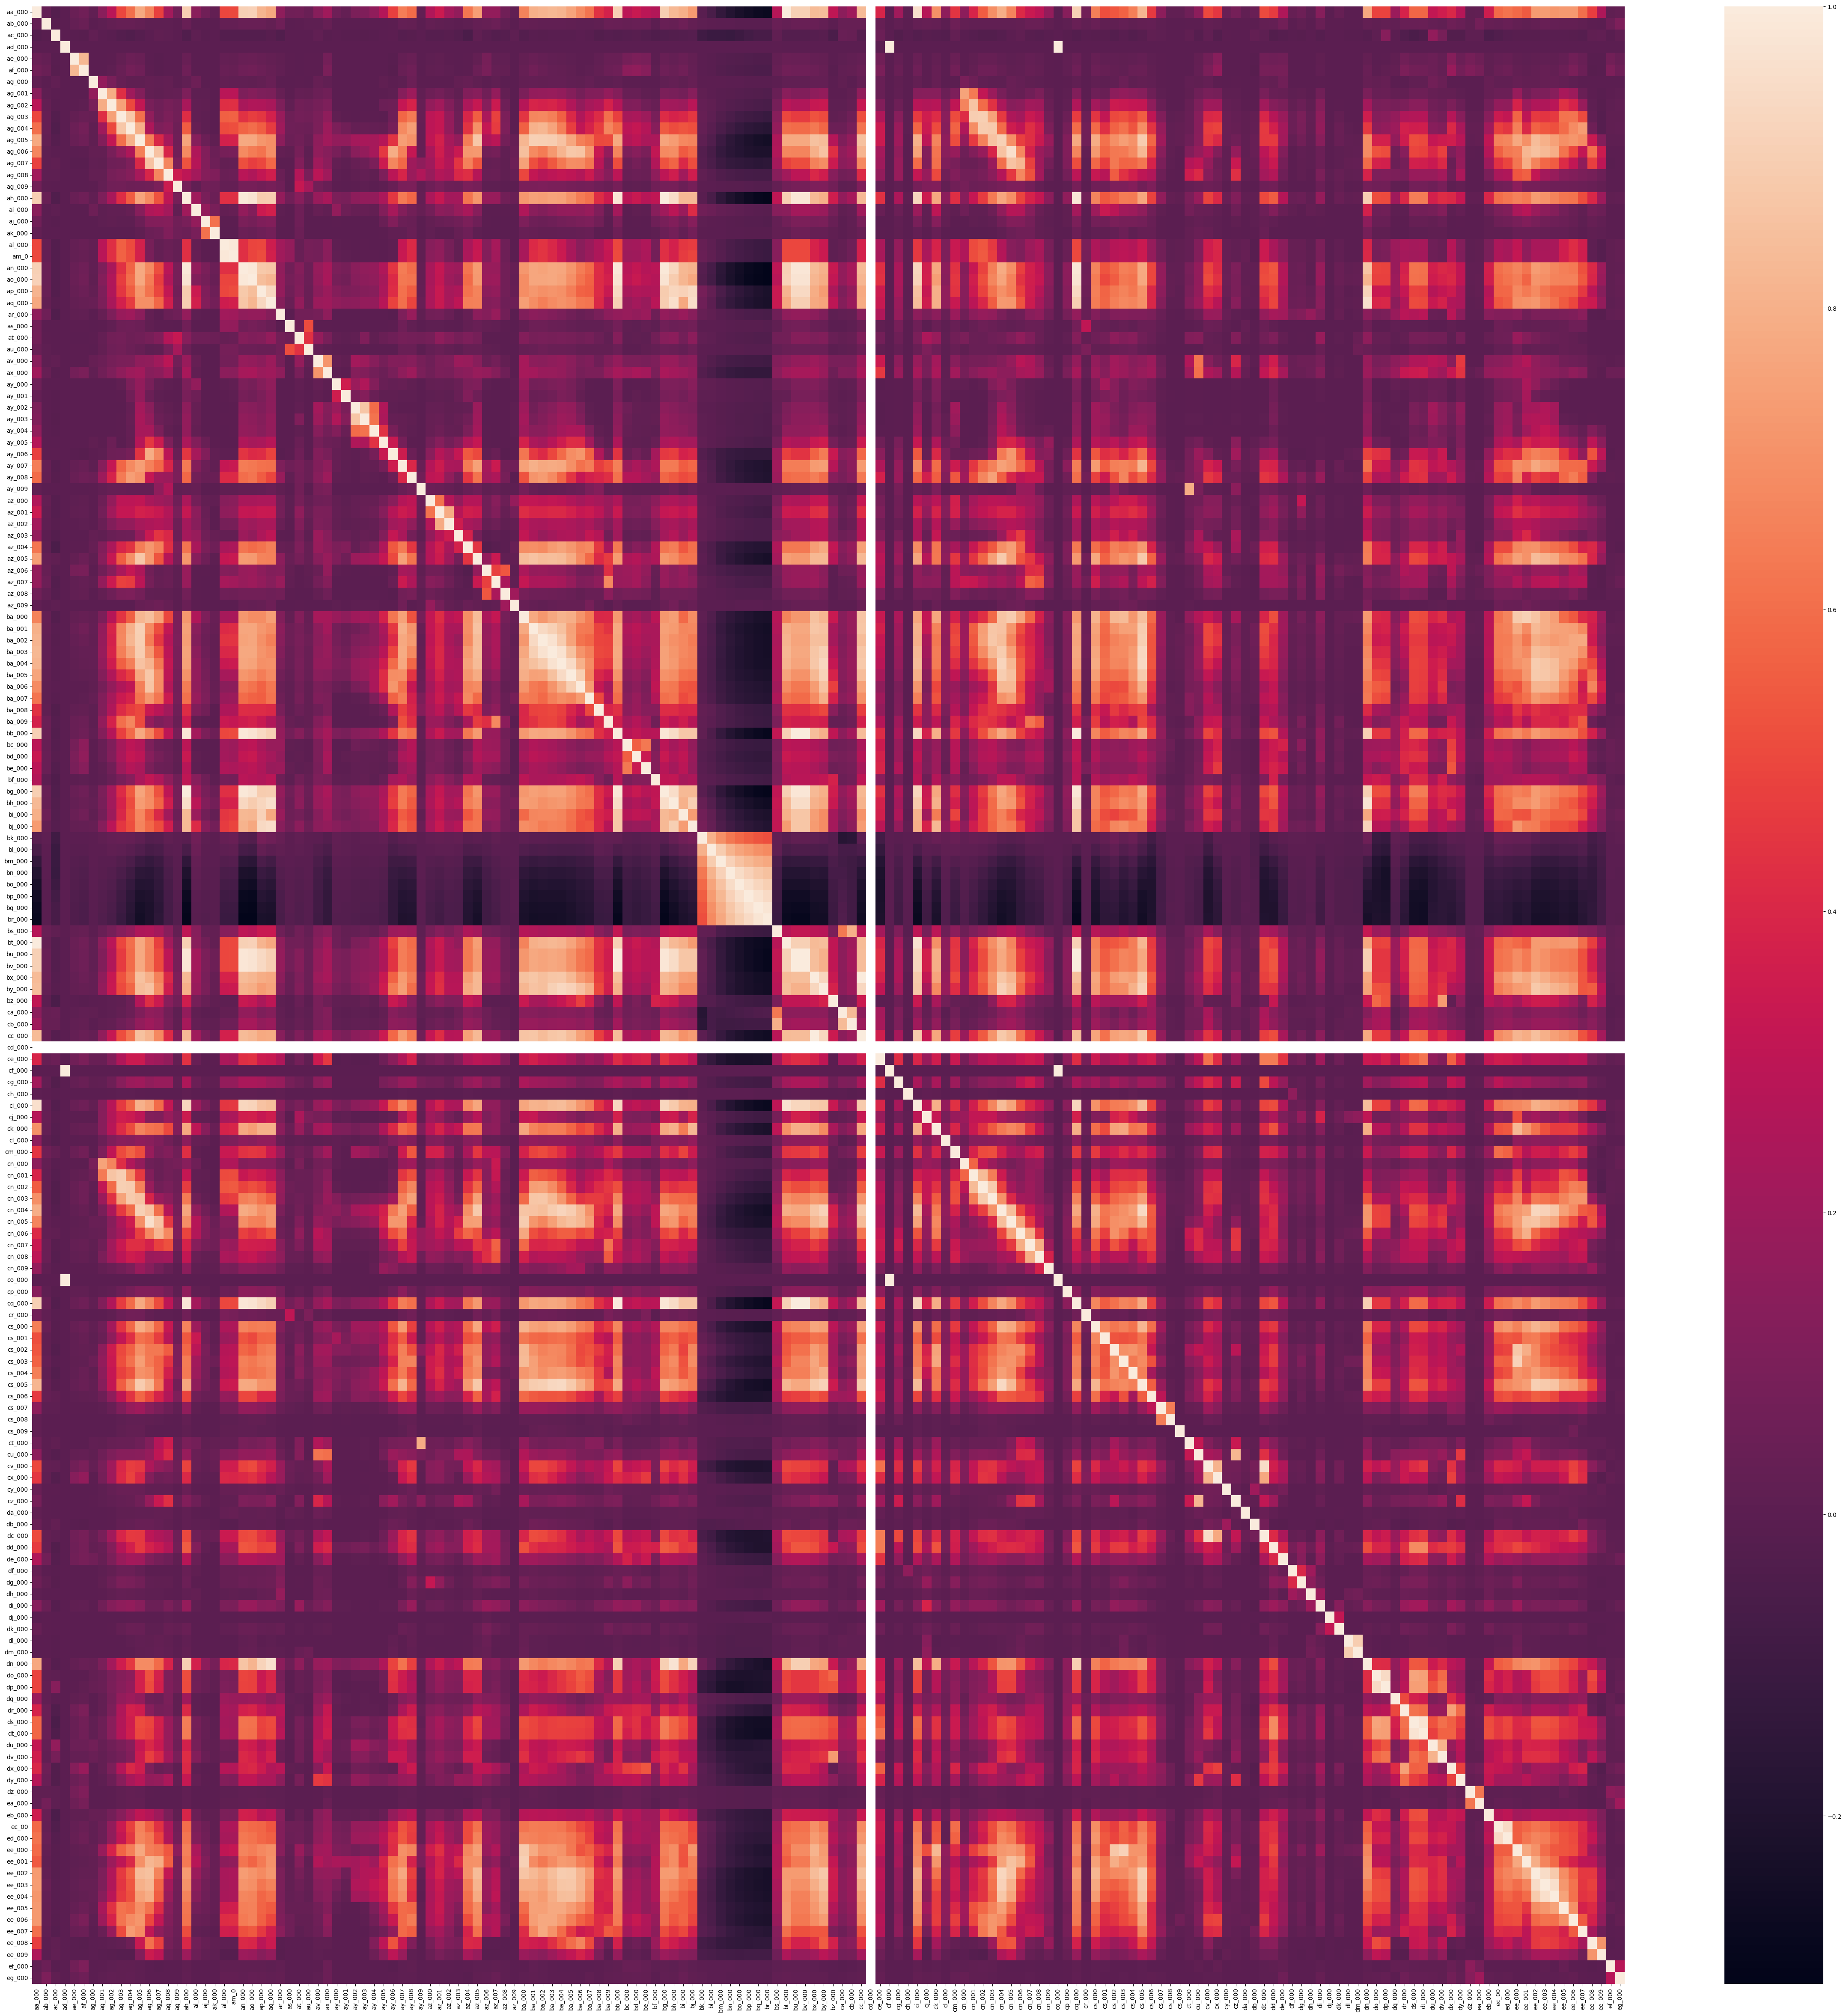

In [37]:
plt.figure(figsize=(60, 60))
corr = IMP_train_df_x.corr()
sns.heatmap(corr)
plt.show()

### 1(b)-iv. Pick...

In [38]:
cv_df_sorted = cv_df.loc['CV'].sort_values(ascending=False)
features_to_select = int(np.sqrt(170))
highest_cv_features = cv_df_sorted[:features_to_select]

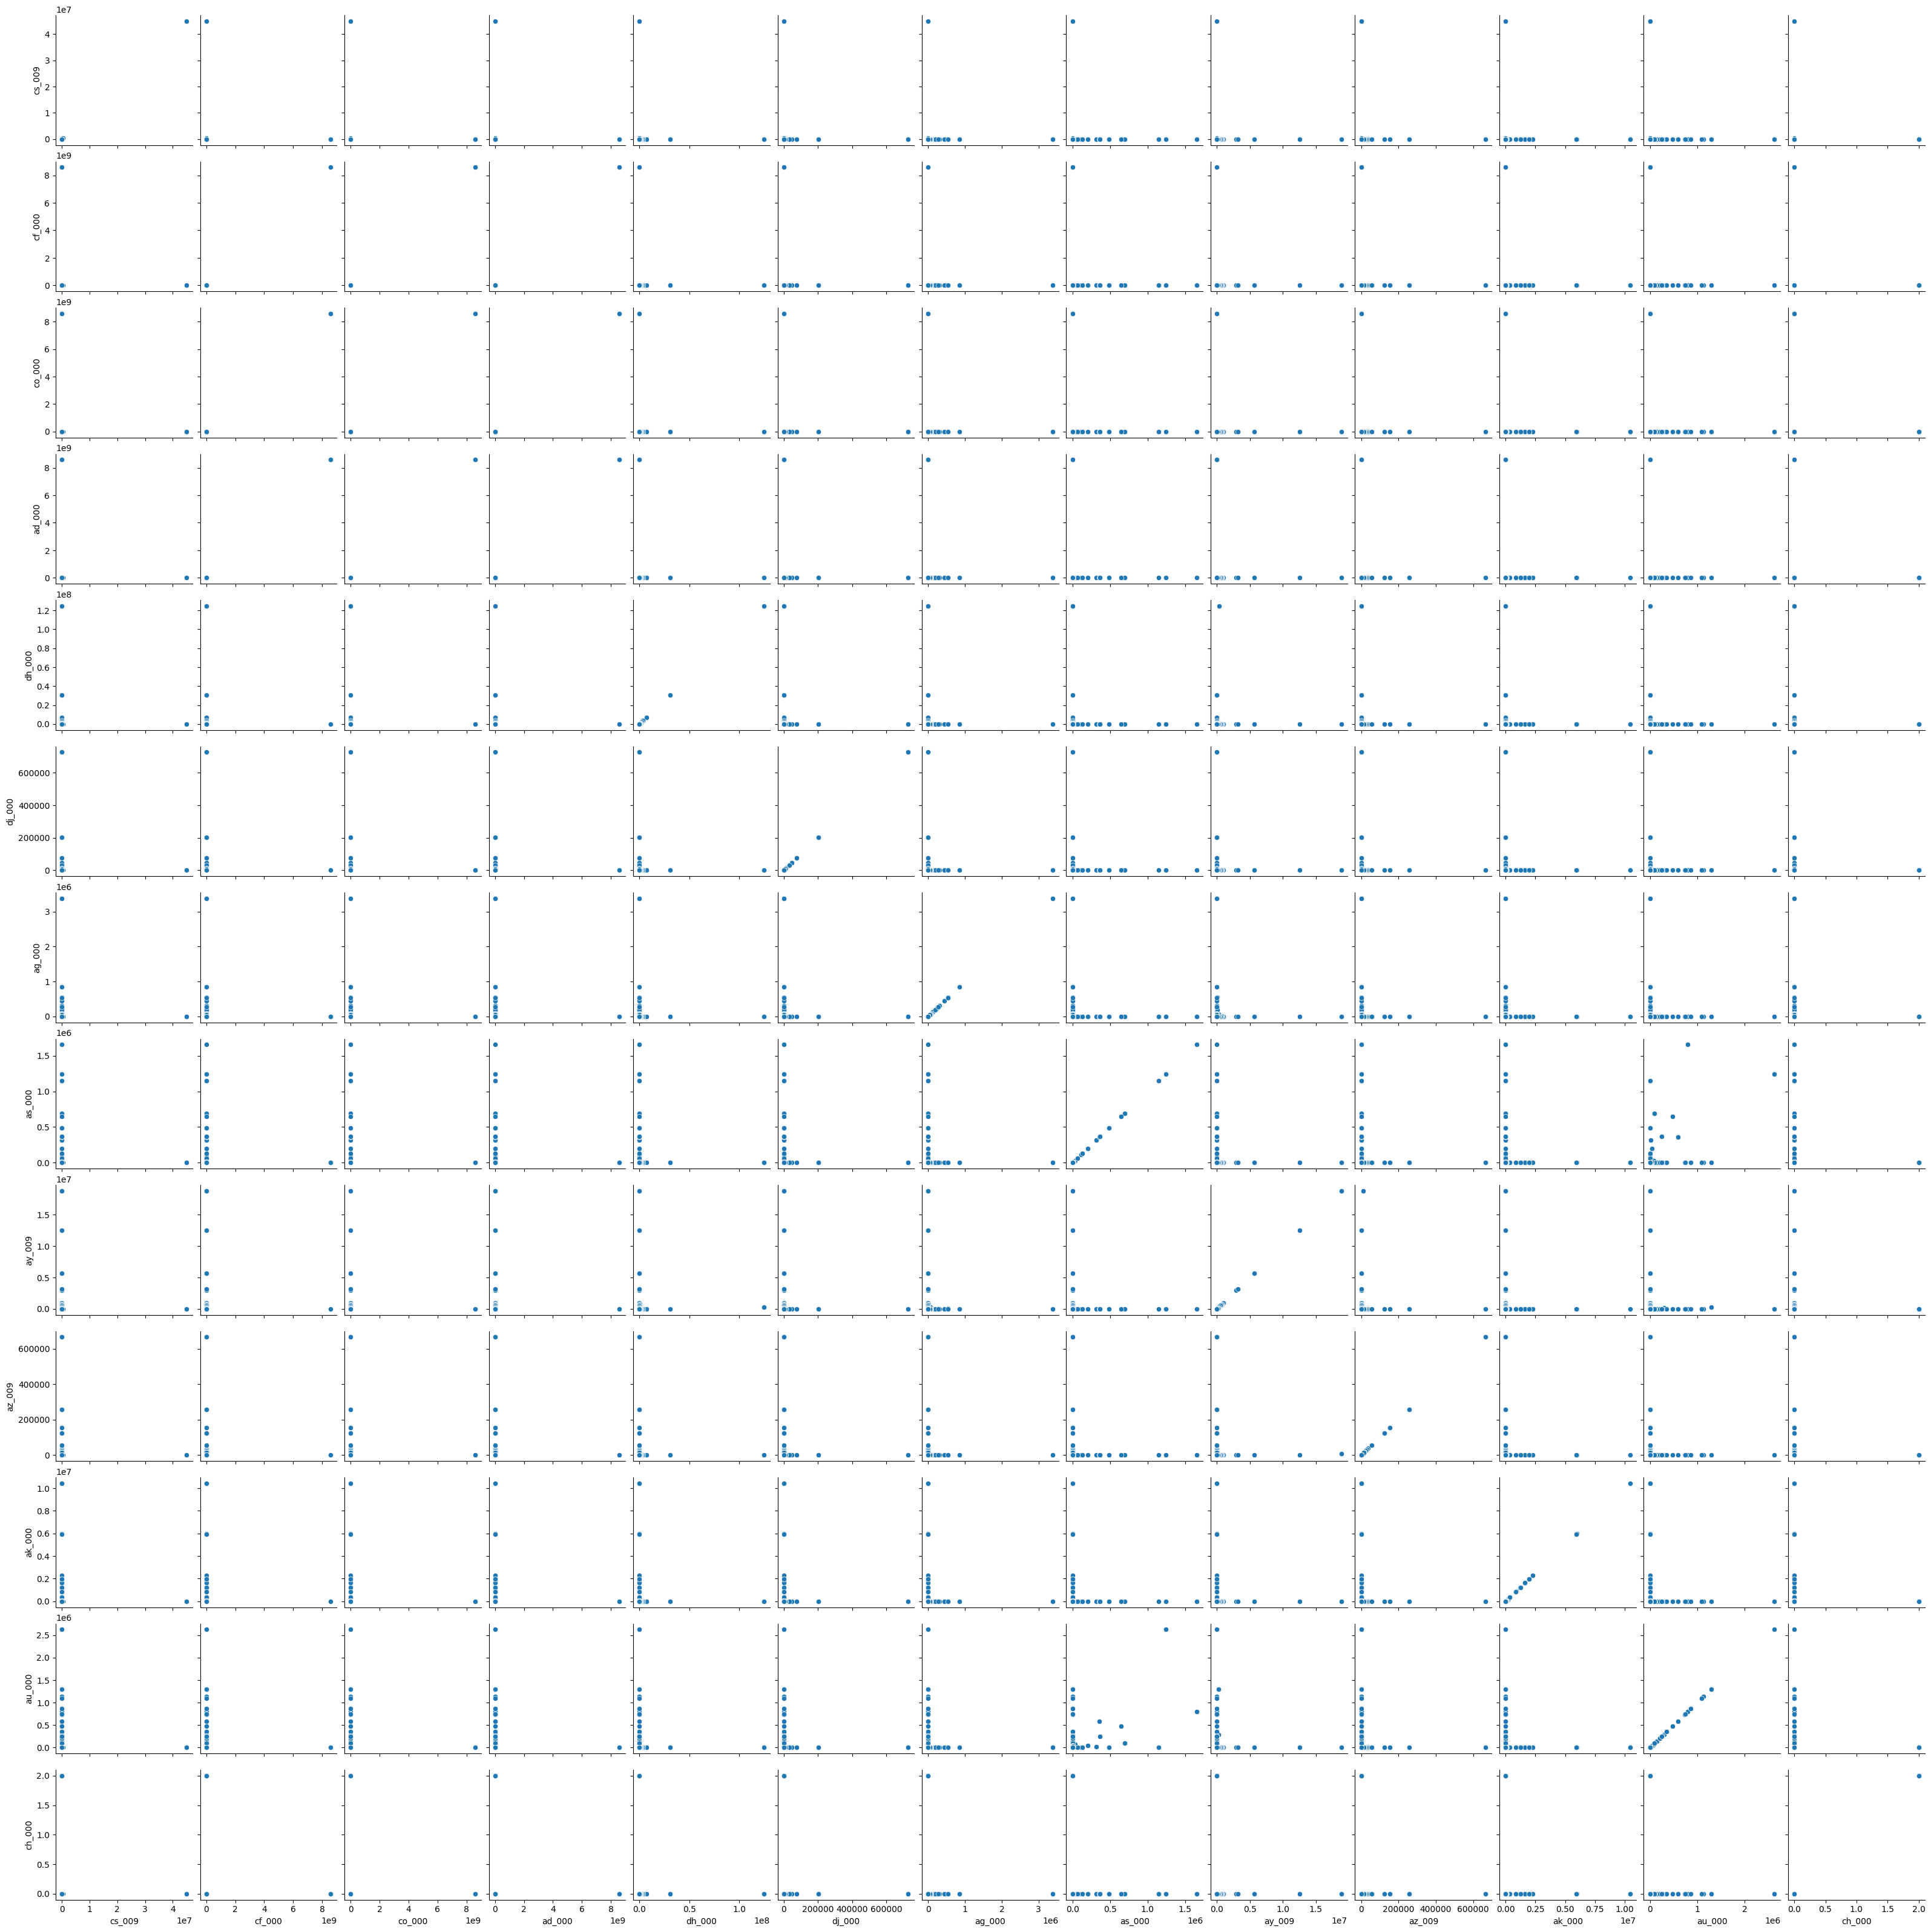

In [39]:
sns.pairplot(IMP_train_df_x[highest_cv_features.index], diag_kind=None)
plt.show()

[]

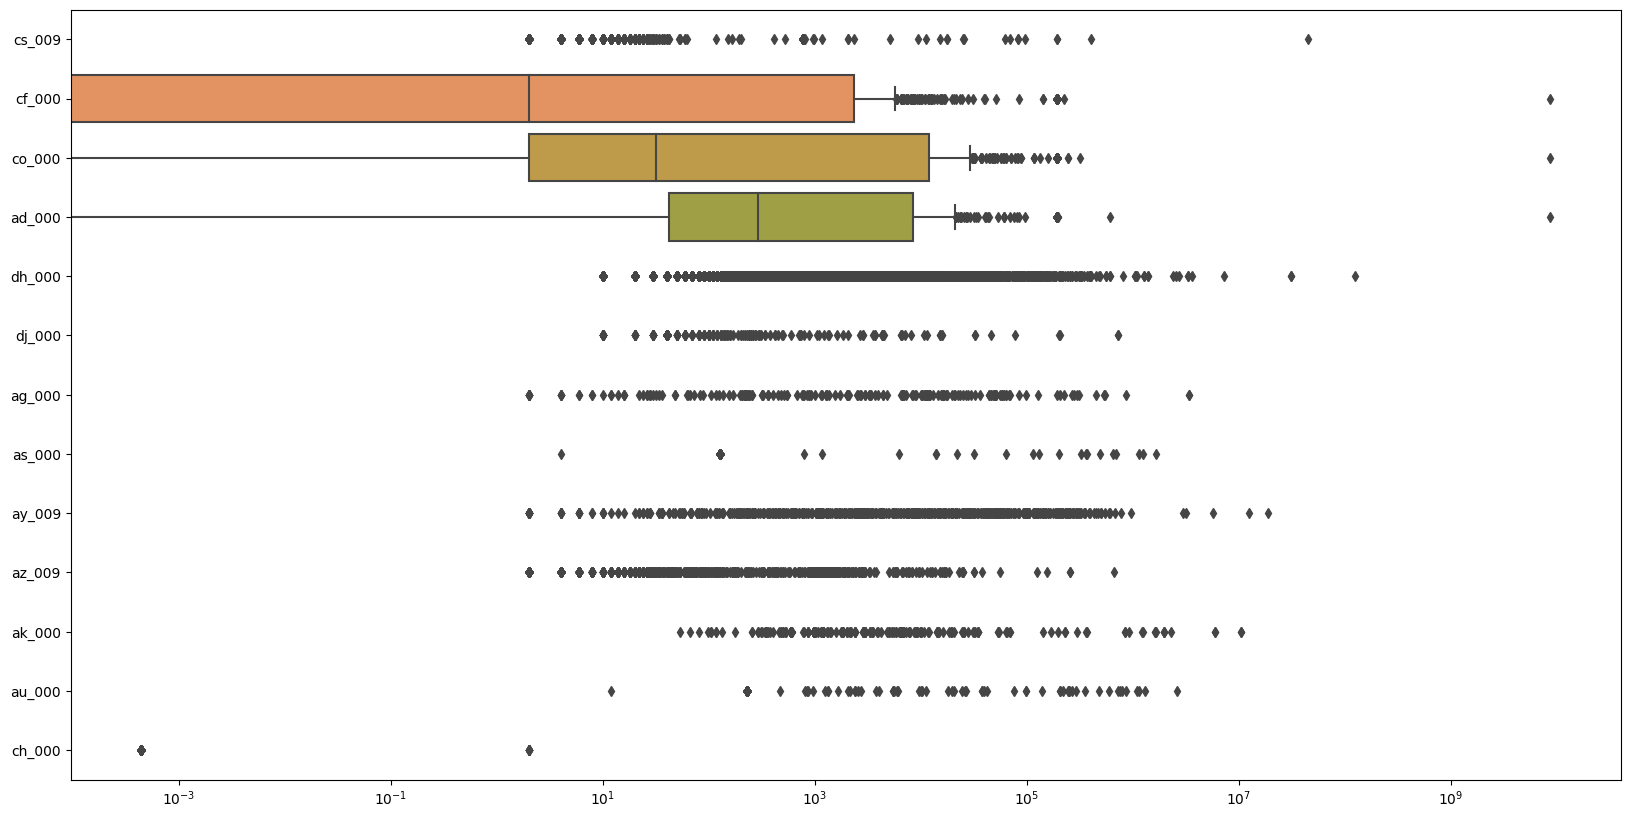

In [40]:
fig, axes = plt.subplots(figsize=(20, 10))
box = sns.boxplot(data=IMP_train_df_x[highest_cv_features.index.to_list()], ax=axes, orient='h')
box.set(xscale='log')
plt.plot()

**conclusions:**
No conclusion can be drawn solely from the scatterplot. 
Any outlier can easily affect the the mean imputation strategy.

### 1(b)-v. Determine the number of positive and negative data. Is this data set imbalanced?

In [41]:
print('Training data set value count:')
print(y_train.value_counts())
print('\n\n')
print('Test dat set value count:')
print(y_test.value_counts())

Training data set value count:
class
0        59000
1         1000
Name: count, dtype: int64



Test dat set value count:
class
0        15625
1          375
Name: count, dtype: int64


**Is this data set imbalanced?:**
The dataset is imbalanced in both train and test.

## 1(c). Train a random forest to classify the data set. Do NOT compensate for class imbalance in the data set. ...

In [42]:
def model_summary_plot(ground_truth, predicted_truth, prob, title):
    
    calculated_accuracy_score = accuracy_score(ground_truth, predicted_truth)
    print('Accuracy Score is:' + str(calculated_accuracy_score) +'\n')
    
    conf_matrix = confusion_matrix(ground_truth, predicted_truth)
    print('Confusion Matrix')
    print(conf_matrix)
    print('\n')

    _, axes = plt.subplots()
    axes.set_title('ROC curves for' + title)
    y_predicted = prob[:, 1]
    fpr, tpr, _ = roc_curve(ground_truth, y_predicted)
    roc_auc = auc(fpr, tpr)
    axes.plot(fpr, tpr, label='ROC Curve Area:' + str(roc_auc))
    axes.plot([0, 1], [0, 1], '--')
    axes.set_xlabel('False Positive Rate')
    axes.set_ylabel('True Positive Rate')
    axes.legend()
    plt.show()

In [43]:
RF_model = RandomForestClassifier(max_depth=5, random_state=RS, oob_score=True)
RF_model.fit(IMP_train_df_x, y_train)

RandomForestClassifier(max_depth=5, oob_score=True, random_state=60000)

Accuracy Score is:0.9920333333333333

Confusion Matrix
[[58972    28]
 [  450   550]]




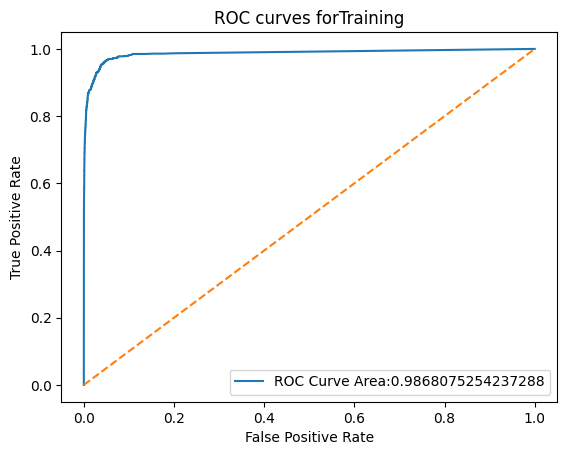

In [44]:
aps_train_y_predicted = RF_model.predict(IMP_train_df_x)
aps_train_y_prob = RF_model.predict_proba(IMP_train_df_x)
model_summary_plot(y_train, aps_train_y_predicted, aps_train_y_prob, 'Training')

Accuracy Score is:0.9879375

Confusion Matrix
[[15612    13]
 [  180   195]]




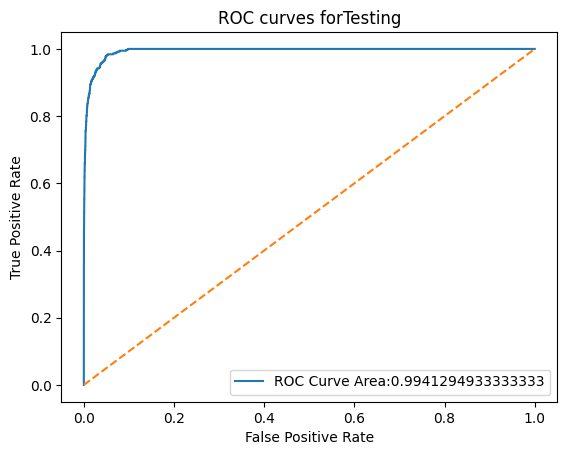

In [45]:
aps_test_y_predicted = RF_model.predict(IMP_test_df_x)
aps_test_y_prob = RF_model.predict_proba(IMP_test_df_x)
model_summary_plot(y_test, aps_test_y_predicted, aps_test_y_prob, 'Testing')

In [46]:
# calculating oob error
train_oob_error = 1 - RF_model.oob_score_
test_error = 1 - accuracy_score(y_test, aps_test_y_predicted)

print('Training OOB Error:' +str(train_oob_error))
print('Test Error:' +str(test_error))

Training OOB Error:0.009366666666666634
Test Error:0.012062499999999976


## 1(d). Research how class imbalance is addressed in random forests. Compensate for class imbalance in your random forest and repeat 1c. Compare the results with those of 1c.

**Research:**
> - **Weighted Random Forests**: In weighted random forests, each tree is trained on a different bootstrapped sample with class weights assigned to the samples. Class weights are calculated based on the inverse of the class frequencies. This allows the random forest to pay more attention to the minority class during training.
> - **Ensemble-Level Techniques**: Techniques can also be applied at the ensemble level to address class imbalance. For example, instead of using majority voting for prediction, threshold-moving can be applied to shift the decision threshold towards the minority class.

Here, I have used the first approach.

Accuracy Score is:0.9588666666666666

Confusion Matrix
[[56563  2437]
 [   31   969]]




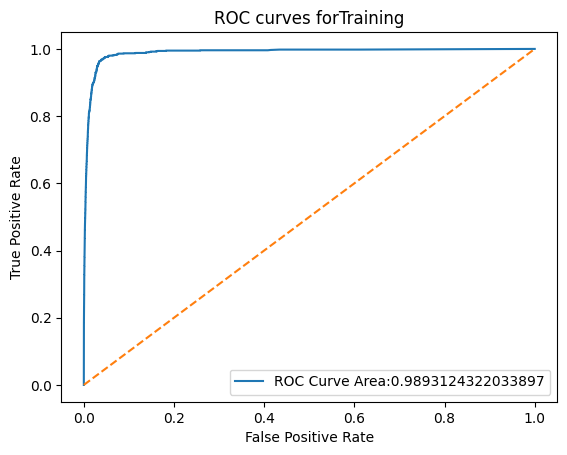

In [47]:
RF_model = RandomForestClassifier(max_depth=5, random_state=RS, class_weight='balanced', oob_score=True)
RF_model.fit(IMP_train_df_x, y_train)
aps_train_y_predicted = RF_model.predict(IMP_train_df_x)
aps_train_y_prob = RF_model.predict_proba(IMP_train_df_x)
model_summary_plot(y_train, aps_train_y_predicted, aps_train_y_prob, 'Training')

Accuracy Score is:0.9595

Confusion Matrix
[[14992   633]
 [   15   360]]




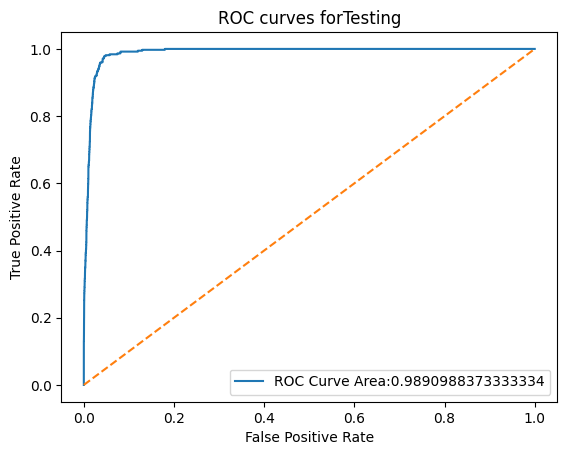

In [48]:
aps_test_y_predicted = RF_model.predict(IMP_test_df_x)
aps_test_y_prob = RF_model.predict_proba(IMP_test_df_x)
model_summary_plot(y_test, aps_test_y_predicted, aps_test_y_prob, 'Testing')

In [49]:
# calculating oob error
train_oob_error = 1 - RF_model.oob_score_
test_error = 1 - accuracy_score(y_test, aps_test_y_predicted)

print('Training OOB Error:' +str(train_oob_error))
print('Test Error:' +str(test_error))

Training OOB Error:0.04244999999999999
Test Error:0.04049999999999998


**Compare the results :**
While the overall accuraccy drops, the weighted approch improves the performance for the minority class (195/375 v.s. 360/375). This was the goal.

## 1(e). XGBoost and Model Trees

In [50]:
# Standardize features by removing the mean and scaling to unit variance.
Scalet = StandardScaler()
x_train = pd.DataFrame(Scalet.fit_transform(IMP_train_df_x),columns=IMP_train_df_x.columns)
x_test = pd.DataFrame(Scalet.fit_transform(IMP_test_df_x),columns=IMP_test_df_x.columns)

In [51]:
estimator = XGBClassifier(objective='binary:logistic', colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 5, use_label_encoder=False)

In [52]:
# C-V
param_grid = {'reg_alpha': [0.05,0.07,0.09, 0.1, 0.15, 0.2, 0.5, 0.75, 1, 2]}
cv = KFold(n_splits=5,shuffle=True,random_state=RS)
grid_cv = GridSearchCV(estimator, 
                       param_grid, 
                       n_jobs=-1, 
                       cv=cv, 
                       scoring='accuracy')

grid_cv.fit(x_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=60000, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.3,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     i...
                                     learning_rate=0.1, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=5,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'reg_alpha': [0.05, 0.07, 0.09, 0.1, 0.15, 0.2, 0.5,
                                       0.75, 1, 2]},
             scoring='accuracy')

In [53]:
alpha_best = grid_cv.best_params_['reg_alpha']
print('The best alpha is ',alpha_best, ' with a cross validation accuracy of ',grid_cv.best_score_)

The best alpha is  0.5  with a cross validation accuracy of  0.9939833333333332


In [54]:
estimator = XGBClassifier(objective='binary:logistic',
                          reg_alpha=alpha_best,
                          colsample_bytree = 0.3, 
                          learning_rate = 0.1,
                          max_depth = 5,
                          use_label_encoder=False,)
estimator.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.3, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [55]:
y_train_pred = estimator.predict(x_train)
y_train_pred_prob = estimator.predict_proba(x_train)

y_test_pred = estimator.predict(x_test)
y_test_pred_prob = estimator.predict_proba(x_test)

Accuracy Score is:0.99815

Confusion Matrix
[[58992     8]
 [  103   897]]




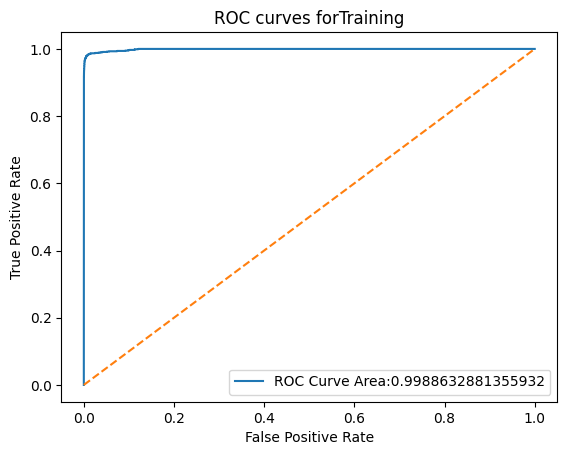

In [56]:
model_summary_plot(y_train.values, y_train_pred, y_train_pred_prob, 'Training')

Accuracy Score is:0.9914375

Confusion Matrix
[[15603    22]
 [  115   260]]




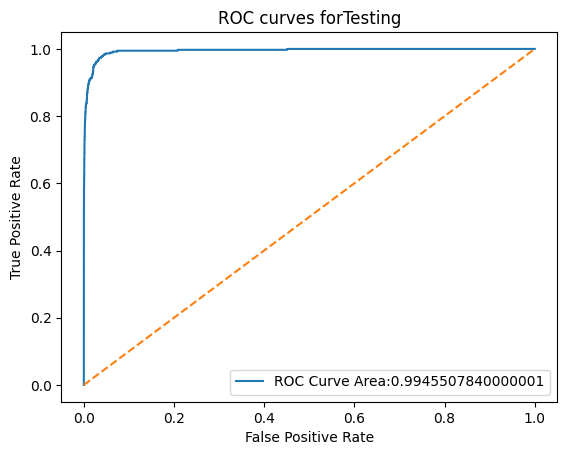

In [57]:
model_summary_plot(y_test, y_test_pred, y_test_pred_prob, 'Testing')

## 1(f). Use SMOTE ...

In [58]:
smote = SMOTE()
x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)

In [59]:
cv = KFold(n_splits=5,shuffle=True,random_state=RS)
cv_smote = GridSearchCV(estimator, 
                       param_grid, 
                       n_jobs=-1, 
                       cv=cv, 
                       scoring='accuracy')
cv_smote.fit(x_train_smote, y_train_smote)

GridSearchCV(cv=KFold(n_splits=5, random_state=60000, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.3,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     i...
                                     learning_rate=0.1, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=5,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'reg_alpha': [0.05, 0.07, 0.09, 0.1, 0.15, 0.2, 0.5,
                                       0.75, 1, 2]},
             scoring='accuracy')

In [60]:
alpha_best = cv_smote.best_params_['reg_alpha']
print('The best alpha is ',alpha_best, ' with a cross validation accuracy of ',cv_smote.best_score_)

The best alpha is  0.09  with a cross validation accuracy of  0.9943474576271185


In [61]:
estimator_smote = XGBClassifier(objective='binary:logistic',
                          reg_alpha=alpha_best,
                          colsample_bytree = 0.3, 
                          learning_rate = 0.1,
                          max_depth = 5,
                          use_label_encoder=False,)
y_train['class'].replace({'neg':0,'pos':1},inplace=True)
estimator_smote.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.3, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [62]:
y_train_pred = estimator_smote.predict(x_train)
y_train_pred_prob = estimator_smote.predict_proba(x_train)

y_test_pred = estimator_smote.predict(x_test)
y_test_pred_prob = estimator_smote.predict_proba(x_test)

Accuracy Score is:0.9983

Confusion Matrix
[[58995     5]
 [   97   903]]




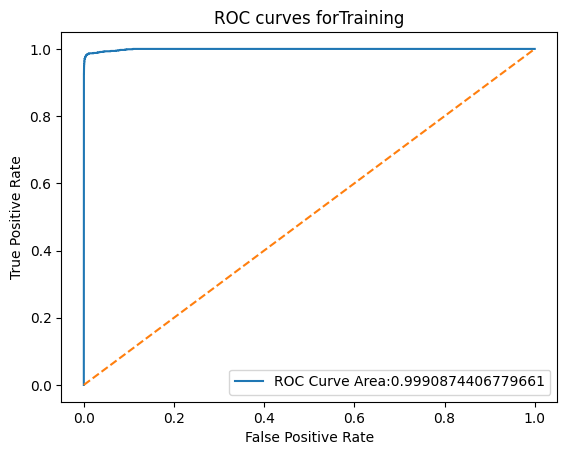

In [63]:
model_summary_plot(y_train.values, y_train_pred, y_train_pred_prob, 'Training')

Accuracy Score is:0.99175

Confusion Matrix
[[15605    20]
 [  112   263]]




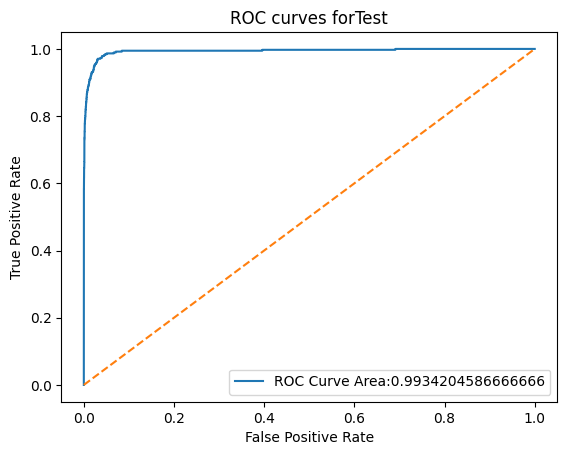

In [64]:
model_summary_plot(y_test, y_test_pred, y_test_pred_prob, 'Test')